In [1]:
import warnings; warnings.simplefilter('ignore')

import sys
sys.path.insert(0, '/home/jcbyts/Repos/')

import Utils as U
import gratings as gt


import NDN3.NDNutils as NDNutils

which_gpu = NDNutils.assign_gpu()
from scipy.ndimage import gaussian_filter
from copy import deepcopy

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt  # plotting
import seaborn as sns

import NDN3.NDN as NDN
import NDN3.Utils.DanUtils as DU

*******************************************************************************************
---> getting list of available GPUs:
[0, 1]

---> getting GPU memory map:
{0: 405, 1: 489}

---> setting up GPU with largest available memory:
   ...picking GPU # 0
*******************************************************************************************

Done!


In [3]:
sesslist = gt.list_sessions()
sesslist = list(sesslist)
for i in range(len(sesslist)):
    print("%d %s" %(i, sesslist[i]))

0 ellie_20170724
1 ellie_20170725
2 ellie_20170726
3 ellie_20170728
4 ellie_20170731
5 ellie_20170801
6 ellie_20170802
7 ellie_20170803
8 ellie_20170807
9 ellie_20170809
10 ellie_20170810
11 ellie_20170811
12 ellie_20170815a
13 ellie_20170815b
14 ellie_20170816
15 ellie_20170817
16 ellie_20170818
17 ellie_20170824
18 ellie_20170828
19 ellie_20180814
20 ellie_20181206
21 ellie_20181223
22 ellie_20181224
23 ellie_20190107
24 ellie_20190111
25 milo_20190607
26 milo_20190621
27 logan_20191202
28 logan_20191203
29 logan_20191204
30 logan_20191205
31 logan_20191206
32 logan_20191226
33 logan_20191230
34 logan_20191231
35 logan_20200106
36 logan_20200107
37 logan_20200109
38 logan_20200110
39 logan_20200115
40 logan_20200226
41 logan_20200228
42 logan_20200229
43 logan_20200302
44 logan_20200303
45 logan_20200304


In [3]:
# reload grating.py if you edited it
import importlib
importlib.reload(gt)

<module 'gratings' from '/home/jcbyts/Repos/V1FreeViewingCode/Analysis/notebooks/gratings.py'>

### Load data Using this repos session management

In [11]:
# Load session (raw)

matdat = gt.load_data(17)


In [4]:
# load and process
indexlist = [17]
stim, sacon, sacoff, Robs, DF, basis, opts, sacbc, valid, eyepos = gt.load_and_setup(indexlist,npow=1.8)
print(opts['exname'])

maxmium SF: 25.51
Using frozen repeats as test set
[16.454256    9.9063835  17.40532     1.3180851   8.38617     3.1457446
  2.9808512   1.1074468   2.8340425   1.156383    2.3957446   1.662766
  3.1148937   1.65        1.230851    4.376596    1.0244681   4.6776595
  1.2404256   7.9319153   0.8191489   1.280851    1.2638298   1.2351063
  0.92659575  0.70531917  8.295744    1.4212766   2.5106385   1.2819148
  1.3021276   0.89042556  0.7510638  32.145744    6.0255322 ]
30 selected
Found 30/35 units that had > 1 spike/sec
['ellie_20170824']


### save data out for quick loading and sharing

In [5]:
# save data
sacbc[0] = 0
sacbc[-1] = 0

sacon = np.append(0, np.diff(sacbc, axis=0)==1).astype('float32')
sacoff = np.append(0, np.diff(sacbc, axis=0)==-1).astype('float32')

opts['stim'] = stim.copy()
opts['sacon'] = sacon.copy()
opts['sacoff'] = sacoff.copy()
opts['basis'] = basis.copy()
opts['Robs'] = Robs.copy()
opts['sacbc'] = sacbc.copy()
opts['valid'] = valid.copy()
opts['eyepos'] = eyepos.copy()

from scipy.io import savemat

savemat('testdata.mat', opts)

### Or, load data here:

In [4]:
from scipy.io import loadmat

opts = loadmat('testdata.mat')

stim = opts['stim']
sacon = opts['sacon']
sacoff = opts['sacoff']
basis = opts['basis']
Robs = opts['Robs']
sacbc = opts['sacbc']
valid = opts['valid']
eyepos = opts['eyepos']
# gotta clean up for the borked way loadmat works
opts['NX'] = opts['NX'][0][0]
opts['NY'] = opts['NY'][0][0]
opts['Ui'] = opts['Ui'][0]
opts['Xi'] = opts['Xi'][0]
opts['Ti'] = opts['Ti'][0]
opts['num_repeats'] = opts['num_repeats'][0][0]

# maybe should also clean up and remove these from opts?

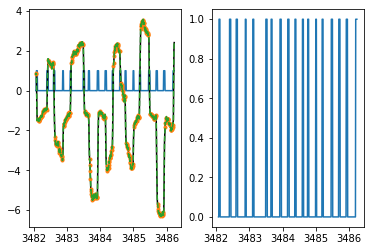

In [6]:
# plot a random segment of saccades to see if they've been labeled
i = np.random.randint(len(sacbc))
ix = np.array(list(range(i, i + 500)))

plt.figure()
plt.subplot(1,2,2)
plt.plot(eyepos[ix,0],sacbc[ix])

plt.subplot(1,2,1)
plt.plot(eyepos[ix,0],sacbc[ix])

h = plt.plot(eyepos[ix,0], eyepos[ix,1], 'k')

ix2 = ix[np.where(sacbc[ix]==0)[0]]

h = plt.plot(eyepos[ix2,0],eyepos[ix2,1], '.')
xd = plt.xlim()

# plot again at the native resolution of the tye tracker
tt = matdat['eyepos'][:,0]
ex = matdat['eyepos'][:,1]
ix = np.logical_and(tt > np.min(eyepos[ix,0]), tt < np.max(eyepos[ix,0]))
plt.plot(tt[ix],ex[ix], '--')

cc=0

In [7]:
# check that saccade alignment works
win = [-50, 50]

# get alignment and sorting
tmp = sacon
tmp[valid==0]=0

ev = np.where(tmp)[0]

sor,xax,sacs = gt.psth(tmp.flatten(), ev, win[0], win[1])

ixd = np.argmin(np.array(xax)**2)
sor[ixd] = 0
sacs[:,ixd]=0

n=sacs.shape[0]
sortnext = np.zeros(n)
sortprev = np.zeros(n)
for i in range(n):
    a = sacs[i,:ixd]
    b = a[::-1]
    sortprev[i] = len(b) - np.argmax(b) - 1
    a = sacs[i,ixd:]
    sortnext[i] = np.argmax(a)

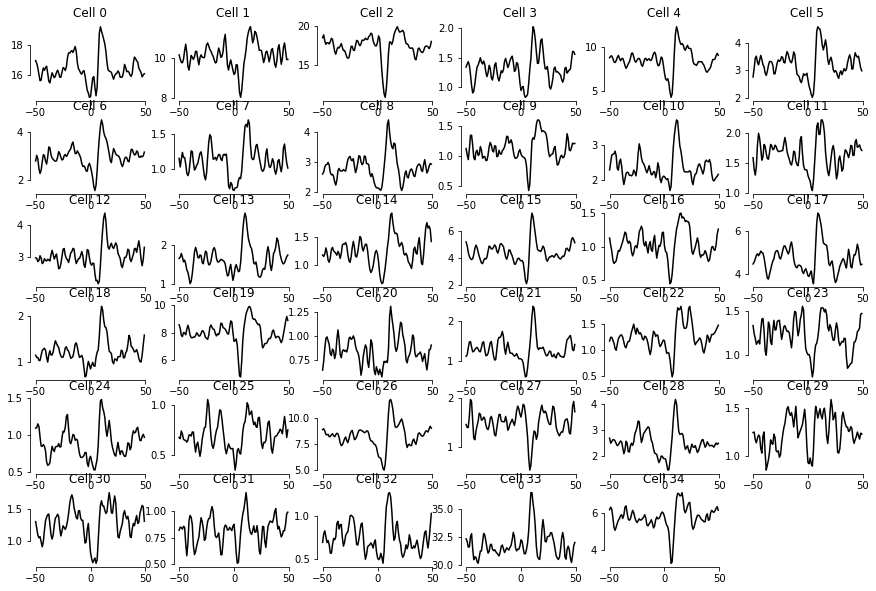

In [7]:
# plot all cells aligned to saccades
NC = Robs.shape[1]
sx,sy = U.get_subplot_dims(NC)
plt.figure(figsize=(15,10))
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
#     Rsmo = Robs[:,cc].flatten()
    Rsmo = gaussian_filter(Robs[:,cc], 1.0)
    m,xax,_ = gt.psth(Rsmo, ev, win[0], win[1])
    plt.plot(xax,m*120, 'k')
    plt.title("Cell %d" %cc)
sns.despine(offset=0, trim=True)

### Pretty much every unit is modulated by saccades. Yes, it's not massive, but c'mon, we should be able to measure this
Below, step through cell by cell to see each saccade

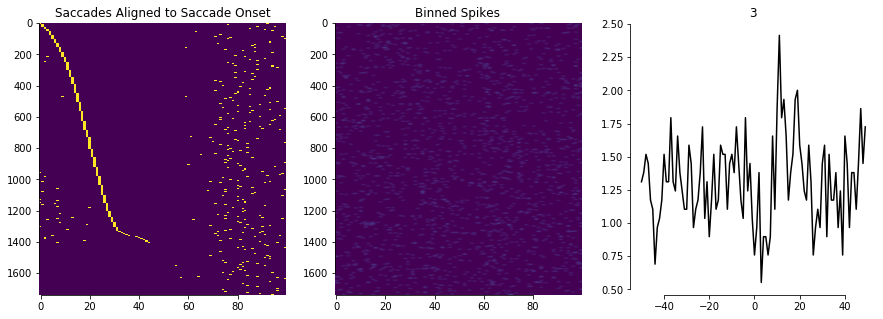

In [13]:
cc += 1
if (cc % 35)==0:
    cc=0

Rsmo = Robs[:,cc].flatten()
_,xax,wf = gt.psth(Rsmo, ev, win[0], win[1])

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
ind = np.argsort(sortprev)
# ind = np.argsort(sortnext)

# ind1 = ind[0:500]
# ind2 = ind[-500:]
plt.imshow(sacs[ind,:], aspect='auto')
plt.title("Saccades Aligned to Saccade Onset")

plt.subplot(1,3,2)
plt.imshow(wf[ind,:]>0,aspect='auto', interpolation='bicubic')
plt.title("Binned Spikes")

plt.subplot(1,3,3)
plt.plot(xax, np.average(wf, axis=0)*120, 'k')
# plt.plot(xax, np.average(wf[ind1,:], axis=0)*120)
# plt.plot(xax, np.average(wf[ind2,:], axis=0)*120)
plt.title(cc)
# cc=3 # set to return to example cell
sns.despine(offset=0, trim=True)

## build time-embedded stimulus

In [11]:
num_saclags = 60 # lags estimated from sac-triggered average (it looks like we need a ~30 post-saccadic lags?)
back_shifts = 20
num_lags = 15
NX = opts['NX']
NY = opts['NY']
NT,NC=Robs.shape

# stimulus
Xstim = NDNutils.create_time_embedding( stim, [num_lags, NX, NY], tent_spacing=1 )
# saccade onset/offset with back_shifts
XsacOn = NDNutils.create_time_embedding( NDNutils.shift_mat_zpad(sacon,-back_shifts,dim=0), [num_saclags, 1, 1], tent_spacing=1)
XsacOff = NDNutils.create_time_embedding( NDNutils.shift_mat_zpad(sacoff,-back_shifts,dim=0), [num_saclags, 1, 1], tent_spacing=1)
# causal filtering
XsacOnCausal = NDNutils.create_time_embedding( sacon, [num_saclags, 1, 1], tent_spacing=1)
XsacOffCausal = NDNutils.create_time_embedding( sacoff, [num_saclags, 1, 1], tent_spacing=1)

Robs = Robs.astype('float32')


## setup optimization parameters

In [12]:
adam_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True}, learning_alg='adam')

early_stopping = 100

adam_params['batch_size'] = 1000
adam_params['display'] = 30
adam_params['MAPest'] = True
adam_params['epochs_training'] = 1000
adam_params['early_stop'] = early_stopping
adam_params['early_stop_mode'] = 1
adam_params['epsilon'] = 1e-8
adam_params['data_pipe_type'] = 'data_as_var' # 'feed_dict'
adam_params['learning_rate'] = 1e-3

lbfgs_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True, 'display': True}, learning_alg='lbfgs')
lbfgs_params['maxiter'] = 10000

noise_dist = 'poisson'
seed = 5
optimizer = 'lbfgs'


if noise_dist=='poisson':
    null_adjusted = True
else:
    null_adjusted = False

if optimizer=='adam':
    opt_params = adam_params
else:
    opt_params = lbfgs_params

## Fit GLM stimulus model

In [14]:
# restrict indices 
ed = np.hypot(eyepos[:,1], eyepos[:,2]) < 20
v = np.intersect1d(np.where(valid)[0], np.where(ed)[0])

# valid indices
Ui = np.intersect1d(opts['Ui'], v)
Xi = np.intersect1d(opts['Xi'], v)
Tiv = np.intersect1d(opts['Ti'], v)

# need to include invalid indices for frozen trials
Ti = opts['Ti']

glm_par = NDNutils.ffnetwork_params(
    input_dims=[1,NX,NY,num_lags],
    layer_sizes=[NC],
    layer_types=['readout'], # readout for cell-specific regularization
    act_funcs=['softplus'],
    normalization=[0],
    reg_list={'d2t': 1e-5, 'd2x': 1e-3, 'l2':1e-5}
)

glm = NDN.NDN([glm_par], tf_seed=seed, noise_dist=noise_dist)

_ = glm.train(input_data=[Xstim], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
    learning_alg=optimizer, opt_params=opt_params, use_dropout=False)

print("Done Training Initial Model")

W0428 15:28:59.727644 140068615477056 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:262: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0428 15:28:59.729093 140068615477056 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:270: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0428 15:28:59.729874 140068615477056 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:273: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0428 15:28:59.730748 140068615477056 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:1094: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0428 15:28:59.739768 140068615477056 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/layer.py:236: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead

Input dimensions: [1, 8, 7, 15]
0: readout (softplus):  	[E35/I0] 


W0428 15:29:00.003240 140068615477056 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0428 15:29:00.069150 140068615477056 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:336: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0428 15:29:00.077391 140068615477056 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:339: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



Done Training Initial Model


### Fit cell-specific regularization (optional and slow)

In [42]:
print("Finding the best regularization")
reg_type = 'd2x'
reg_min=gt.find_best_reg(glm, input_data=[Xstim], output_data=Robs,
    train_indxs=Ui, test_indxs=Xi, reg_type=reg_type, reg_vals=[1e-6, 1e-4, 1e-3, 1e-2, 1e-1],
    opt_params=lbfgs_params, learning_alg='lbfgs')

glm.set_regularization(reg_type=reg_type, reg_val=reg_min, ffnet_target=0, layer_target=0)

reg_type = 'd2t'
reg_min=gt.find_best_reg(glm, input_data=[Xstim], output_data=Robs,
    train_indxs=Ui, test_indxs=Xi, reg_type=reg_type, reg_vals=[1e-6, 1e-4, 1e-3, 1e-2, 1e-1],
    opt_params=lbfgs_params, learning_alg='lbfgs')

glm.set_regularization(reg_type=reg_type, reg_val=reg_min, ffnet_target=0, layer_target=0)


print("Done. Retraining...")
_ = glm.train(input_data=[Xstim], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
    learning_alg=optimizer, opt_params=opt_params, use_dropout=False)

print("Done")

Finding the best regularization
0 (d2x = 1e-06): 5.065609
1 (d2x = 0.0001): 4.822838
2 (d2x = 0.001): 4.728382
3 (d2x = 0.01): 4.7202783
4 (d2x = 0.1): 4.78104
0 (d2t = 1e-06): 4.701071
1 (d2t = 0.0001): 4.6987276
2 (d2t = 0.001): 4.6997995
3 (d2t = 0.01): 4.7116303
4 (d2t = 0.1): 4.732519
Done. Retraining...
Done


## Check how well the stimulus model fit

In [13]:
win = [-20, 20]

# don't fit saccade kernels when no saccades occur... should not be necessary
sacinds = np.unique(np.expand_dims(np.where(sacon)[0], axis=1) + np.arange(win[0],win[1],1))
sacinds = np.delete(sacinds, np.where(sacinds<0))
sacinds = np.delete(sacinds, np.where(sacinds>=len(sacon)))

Uis = np.intersect1d(Ui, sacinds)
Xis = np.intersect1d(Xi, sacinds)
Tis = np.intersect1d(Tiv, sacinds)


W0428 15:32:39.686256 140068615477056 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:1238: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



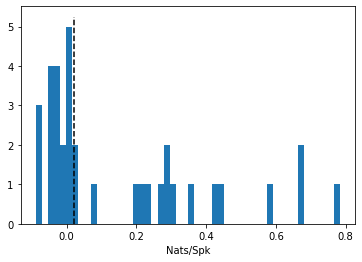

In [15]:

LLx0 = glm.eval_models(input_data=[Xstim], output_data=Robs, data_indxs=Ti, nulladjusted=null_adjusted)

RpredG = glm.generate_prediction(input_data=[Xstim])

g0 = glm.generate_prediction(input_data=[Xstim], pre_activation=True)

plt.figure()
thresh = 0.02
plt.hist(LLx0, 50)
plt.plot([thresh, thresh], plt.ylim(), 'k--')
if noise_dist=='poisson':
    plt.xlabel('Nats/Spk')
else:
    plt.xlabel('MSE?')
    

Text(0.5, 1.0, 'cell 4, r2: 0.58')

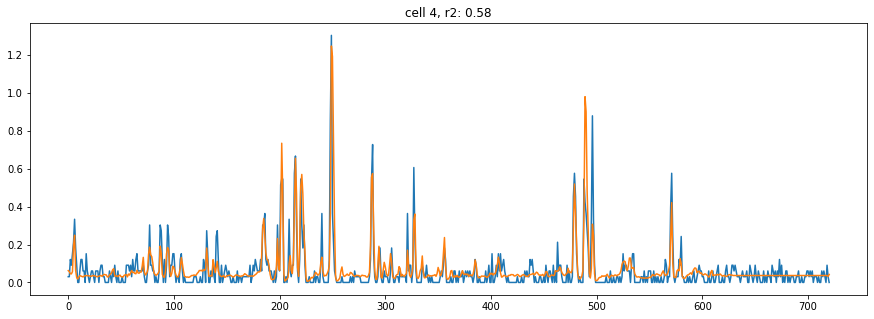

In [16]:
# plot that good example cell
cc = 4
plt.figure(figsize=(15,5))
Ti = opts['Ti']
r = np.reshape(Robs[Ti,cc], (opts['num_repeats'],-1))
rG = np.reshape(RpredG[Ti,cc], (opts['num_repeats'],-1))
# rP = np.reshape(RpredP[Ti,cc], (opts['num_repeats'],-1))
r = np.average(r, axis=0)
rG = np.average(rG, axis=0)
# rP = np.average(rP, axis=0)
plt.plot(r)
plt.plot(rG, '-')
# plt.plot(rP, '--')

r2G = U.r_squared(np.reshape(r, (-1,1)), np.reshape(rG, (-1,1)))
# r2P = U.r_squared(np.reshape(r, (-1,1)), np.reshape(rP, (-1,1)))

plt.title("cell %d, r2: %0.2f" %(cc,r2G))

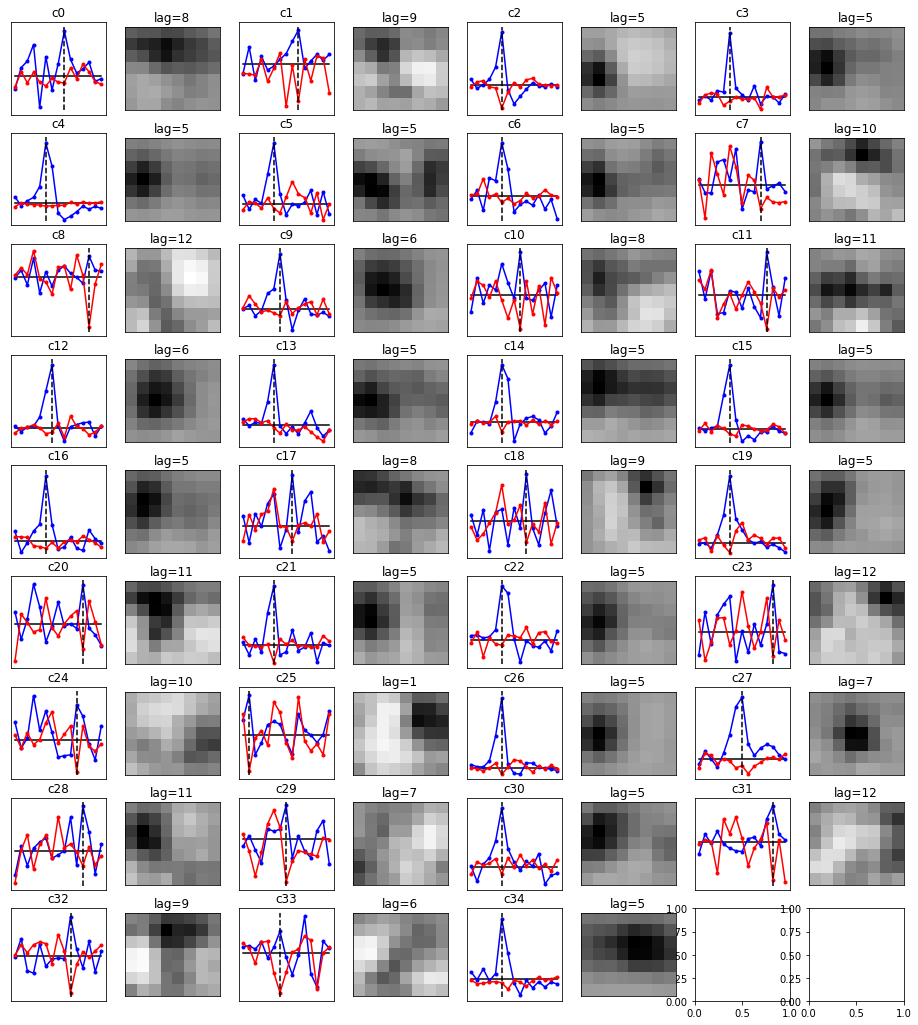

In [17]:
DU.plot_3dfilters(glm)

# r2G = U.r_squared(np.reshape(r, (-1,1)), np.reshape(rG, (-1,1)))
# r2P = U.r_squared(np.reshape(r, (-1,1)), np.reshape(rP, (-1,1)))

## Now add the saccade kernel

In [18]:
stim_par = glm_par.copy()  # copy the stimulus parameters from the GLM
stim_par['activation_funcs'][0] = 'lin' # switch to linear activation, softplus will still be on the output
stim_par

{'network_type': 'normal',
 'xstim_n': [0],
 'ffnet_n': None,
 'input_dims': [1, 8, 7, 15],
 'layer_sizes': [35],
 'layer_types': ['readout'],
 'activation_funcs': ['lin'],
 'normalize_weights': [0],
 'time_expand': [0],
 'reg_initializers': [{'d2t': 1e-05, 'd2x': 0.001, 'l2': 1e-05}],
 'weights_initializers': ['normal'],
 'num_inh': [0],
 'pos_constraints': [None],
 'log_activations': False,
 'conv_filter_widths': [None],
 'shift_spacing': [1],
 'dilation': [1]}

In [19]:
cids = np.where(LLx0>-1000)[0] # don't include junk cells

NC2 = len(cids);
stim_par['layer_sizes'] = [NC2]

# saccade params aligned to onset
sac_on_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags],
    xstim_n=[1],
    layer_sizes=[NC2], # conv_filter_widths=[1], 
    layer_types=['readout'], act_funcs=['lin'], 
    normalization=[0],
    reg_list={'d2t':[1],'l2':[None], 'l1':[1e-3]}
)


# combine the onset kernel
comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,1], layer_sizes=[NC2],
    layer_types=['add'], act_funcs=['softplus']
)

# initialize NDN
ndn0 = NDN.NDN([stim_par, sac_on_par, comb_par], noise_dist=noise_dist)

# set cell-specific regularization
reg_type='d2t'
vals = glm.networks[0].layers[0].reg.vals[reg_type]
ndn0.set_regularization(reg_type=reg_type,reg_val=vals[cids], ffnet_target=0, layer_target=0)

reg_type='d2x'
vals = glm.networks[0].layers[0].reg.vals[reg_type]
ndn0.set_regularization(reg_type=reg_type,reg_val=vals[cids], ffnet_target=0, layer_target=0)

Input dimensions: [1, 1, 1, 60]
0: readout (lin):  	[E35/I0] 
0: add (softplus):  	[E35/I0] 


## Before fitting

Can I set the parameters of this model so that I reproduce the GLM? Why am I having trouble with this

Thre are three networks with one layer each

L2 = 'add'
L1 = normal --> saccade
L0 = normal --> stim

GLM = softplus(L0.W*Xstim + L0.b)

GLMsac = softplus( L2.W(1)*(L0.W + L0.b) + L2.W(2)*(L1.W + L1.b) + L2.b)... right?

so, if I set the L2 weights to 1, the L1 weights/bias to 0

In [20]:
# try to set all parameters so you can produce the same output as the first GLM

# stimulus is the same
ndn0.networks[0].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights[:,cids])
ndn0.networks[0].layers[0].biases = deepcopy(glm.networks[0].layers[0].biases[0,cids])

# saccade does nothing
# ndn0.networks[1].layers[0].weights *= 0
# ndn0.networks[1].layers[0].biases *= 0 

# add network has 0 bias and weights 1
ndn0.networks[2].layers[0].weights /= ndn0.networks[2].layers[0].weights
# ndn0.networks[2].layers[0].weights[1,:] *=0
# ndn0.networks[2].layers[0].biases *= 0 

print("Done")

Done


Text(0.5, 1.0, 'cell 4, r2: 0.58, 0.58')

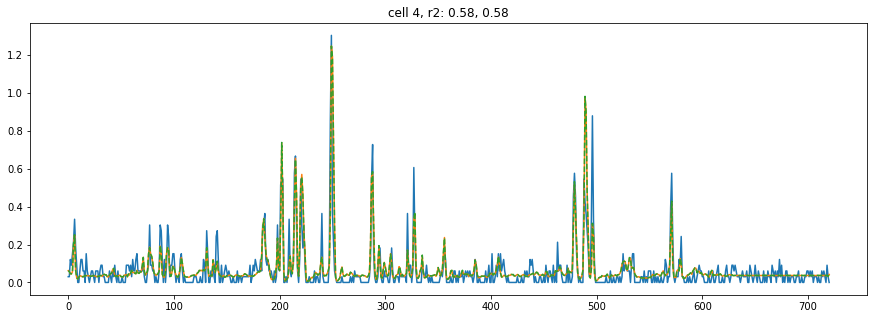

In [21]:
Rpred00 = ndn0.generate_prediction(input_data=[Xstim, XsacOn])

plt.figure(figsize=(15,5))
cc = 4
Ti = opts['Ti']
r = np.reshape(Robs[Ti,cc], (opts['num_repeats'],-1))
r0 = np.reshape(RpredG[Ti,cc], (opts['num_repeats'],-1))
r1 = np.reshape(Rpred00[Ti,cc], (opts['num_repeats'],-1))
r = np.average(r, axis=0)
r0 = np.average(r0, axis=0)
r1 = np.average(r1, axis=0)
plt.plot(r)
plt.plot(r0, '-')
plt.plot(r1, '--')

r20 = U.r_squared(np.reshape(r, (-1,1)), np.reshape(r0, (-1,1)))
r21 = U.r_squared(np.reshape(r, (-1,1)), np.reshape(r1, (-1,1)))

plt.title("cell %d, r2: %0.2f, %0.2f" %(cc,r20, r21))


## Why is the green trace so far off? I clearly don't understand how the add layer works

## Train

In [22]:


# skip stimulus parameters
v2f0 = ndn0.fit_variables(layers_to_skip=[[0], [],[0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn0.train(input_data=[Xstim, XsacOn], output_data=Robs[:,cids], train_indxs=Ui, test_indxs=Xi,
    learning_alg=optimizer, opt_params=opt_params, use_dropout=False, fit_variables=v2f0, silent=False)

ndn1 = ndn0.copy_model()

print("Done")

Done


In [23]:
reg_type = 'l1'
reg_min=gt.find_best_reg(ndn0, input_data=[Xstim, XsacOn], output_data=Robs[:,cids],
    train_indxs=Ui, test_indxs=Xi, reg_type=reg_type,ffnet_target=1,layer_target=0,
    reg_vals=[1e-6, 1e-4, 1e-3, 1e-2, 1e-1],
    fit_variables=v2f0,
    opt_params=lbfgs_params, learning_alg='lbfgs')

ndn0.set_regularization(reg_type=reg_type, reg_val=reg_min, ffnet_target=1, layer_target=0)


reg_type = 'd2t'
reg_min=gt.find_best_reg(ndn0, input_data=[Xstim, XsacOn], output_data=Robs[:,cids],
    train_indxs=Ui, test_indxs=Xi, reg_type=reg_type,ffnet_target=1,layer_target=0,
    reg_vals=[1e-3, 1e-2, 1e-1, 1, 5],
    fit_variables=v2f0,
    opt_params=lbfgs_params, learning_alg='lbfgs')

ndn0.set_regularization(reg_type=reg_type, reg_val=reg_min, ffnet_target=1, layer_target=0)

_ = ndn0.train(input_data=[Xstim, XsacOn], output_data=Robs[:,cids], train_indxs=Ui, test_indxs=Xi,
    learning_alg=optimizer, opt_params=opt_params, use_dropout=False, fit_variables=v2f0, silent=False)
print("Done")



0 (l1 = 1e-06): 4.708888
1 (l1 = 0.0001): 4.7089386
2 (l1 = 0.001): 4.7107663
3 (l1 = 0.01): 4.727567
4 (l1 = 0.1): 4.7283535
0 (d2t = 0.001): 4.7263536
1 (d2t = 0.01): 4.711439
2 (d2t = 0.1): 4.7052464
3 (d2t = 1): 4.7075586
4 (d2t = 5): 4.7127447
Done


In [73]:
# don't skip stimulus parameters
v2f0 = ndn0.fit_variables(layers_to_skip=[[], [],[0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn0.train(input_data=[Xstim, XsacOn], output_data=Robs[:,cids], train_indxs=Uis, test_indxs=Xis,
    learning_alg=optimizer, opt_params=opt_params, use_dropout=False, fit_variables=v2f0, silent=False)
print("Done")

0 (d2t = 1e-06): 0.03685302
1 (d2t = 0.0001): 0.037150927
2 (d2t = 0.001): 0.037154235
3 (d2t = 0.01): 0.03685302
4 (d2t = 0.1): 0.03712968
5 (d2t = 1): 0.036903124
6 (d2t = 10): 0.036904164
Done


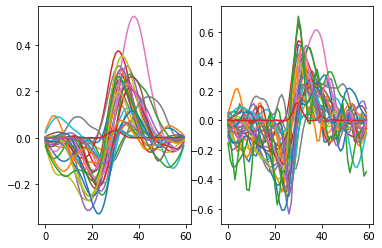

In [24]:
# plot saccade kernels
plt.figure()
plt.subplot(1,2,1)
f = plt.plot(ndn1.networks[1].layers[0].weights)
plt.subplot(1,2,2)
f = plt.plot(ndn0.networks[1].layers[0].weights)

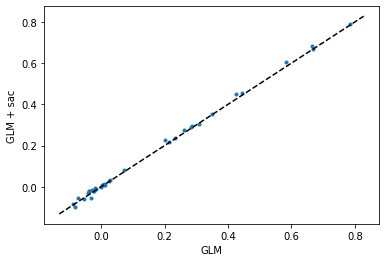

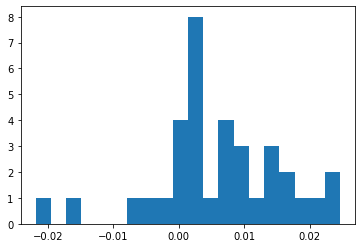

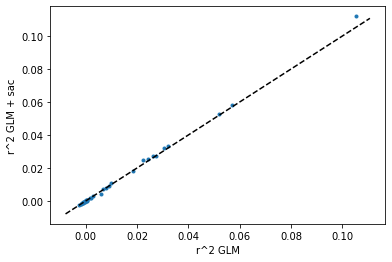

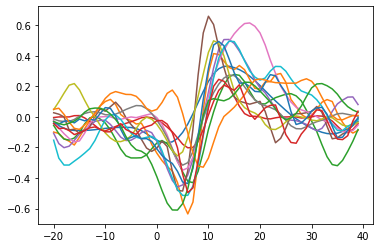

In [34]:
LLx0 = glm.eval_models(input_data=[Xstim], output_data=Robs, data_indxs=Ti, nulladjusted=null_adjusted)
LLx1 = ndn0.eval_models(input_data=[Xstim, XsacOn], output_data=Robs[:,cids], data_indxs=Ti, nulladjusted=null_adjusted)
Rpred1 = ndn0.generate_prediction(input_data=[Xstim, XsacOn])
Rpred0 = glm.generate_prediction(input_data=[Xstim])

# rsquared (for gaussian model)
r20 = U.r_squared(Robs, Rpred0, data_indxs=Ti)[cids]
r21 = U.r_squared(Robs[:,cids], Rpred1, data_indxs=Ti)

plt.figure()
plt.plot(LLx0[cids], LLx1, '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.xlabel('GLM')
plt.ylabel('GLM + sac')

plt.figure()
f = plt.hist(LLx1 - LLx0[cids], 20)

plt.figure()
plt.plot(r20, r21, '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.xlabel('r^2 GLM')
plt.ylabel('r^2 GLM + sac')

plt.figure()
xax = np.arange(-back_shifts, num_saclags-back_shifts, 1)
f = plt.plot(xax,ndn0.networks[1].layers[0].weights[:,LLx1>.2])

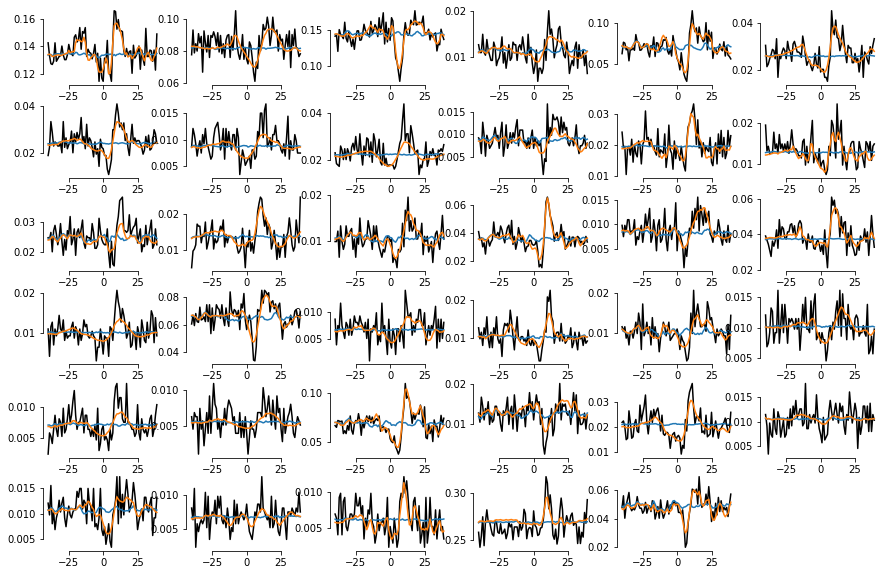

In [36]:
ev = np.where(sacon)[0]

win = [-40,40]
NC = Robs.shape[1]
sx,sy = U.get_subplot_dims(NC)
plt.figure(figsize=(15,10))
for cc in range(NC2):
    plt.subplot(sx,sy,cc+1)
    m,xax,wf = gt.psth(Robs[:,cids[cc]], ev, win[0], win[1])
    m0,xax,wf0 = gt.psth(Rpred0[:,cids[cc]], ev, win[0], win[1])
    m1,xax,wf1 = gt.psth(Rpred1[:,cc], ev, win[0], win[1])

    plt.plot(xax, m, 'k')
    plt.plot(xax,m0)
    plt.plot(xax,m1)

sns.despine(offset=0, trim=True)

### Spent some time trying to diagnose belew, but didn't get anywhere

In [189]:
cc = 3
nbins = 50
def empiricalNonlinearity(g, r, nbins=50):
    if type(nbins)!=int:
        binEdges = nbins
        nbins = len(binEdges)
    else:    
        binEdges = np.percentile(g, np.linspace(0, 100, nbins))
        
    id = np.digitize(g, binEdges)
    spkNL = np.zeros(nbins)
    for i in range(nbins):
        spkNL[i]=np.average(r[id==i])
    return spkNL,binEdges
        
# plt.plot(g0, Rpred0, '.')

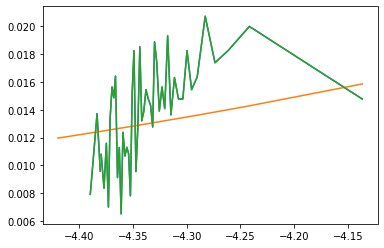

In [197]:
cc += 1
spkNL,binEdges = empiricalNonlinearity(g0[:,cc], Robs[:,cc])

plt.plot(binEdges, spkNL)
plt.plot(binEdges, np.log(1 + np.exp(binEdges)))

spkNL,binEdges = empiricalNonlinearity(g0[:,cc], Robs[:,cc], nbins=binEdges)    
plt.plot(binEdges, spkNL)

array([-0.00600839], dtype=float32)

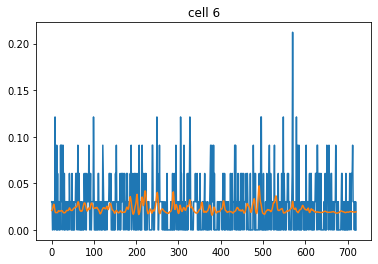

In [192]:
cc += 1
Ti = opts['Ti']
r = np.reshape(Robs[Ti,cc], (opts['num_repeats'],-1))
r0 = np.reshape(Rpred1[Ti,cc], (opts['num_repeats'],-1))
r = np.average(r, axis=0)
r0 = np.average(r0, axis=0)
plt.plot(r)
plt.plot(r0)
plt.title("cell %d" %cc)
U.r_squared(np.reshape(r, (-1,1)), np.reshape(r0, (-1,1)))

In [185]:
g0 = glm.generate_prediction(input_data=[Xstim], pre_activation=True)

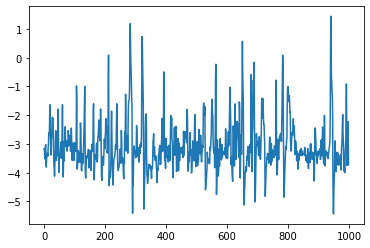

In [105]:
cc=4
plt.plot(g0[1:1000,cc])

In [186]:
# check that saccade alignment works
win = [-50, 50]

# get alignment and sorting
tmp = sacon
tmp[valid==0]=0

ev = np.where(tmp)[0]

sor,xax,sacs = gt.psth(tmp.flatten(), ev, win[0], win[1])

ixd = np.argmin(np.array(xax)**2)
sor[ixd] = 0
sacs[:,ixd]=0

n=sacs.shape[0]
sortnext = np.zeros(n)
sortprev = np.zeros(n)
for i in range(n):
    a = sacs[i,:ixd]
    b = a[::-1]
    sortprev[i] = len(b) - np.argmax(b) - 1
    a = sacs[i,ixd:]
    sortnext[i] = np.argmax(a)

In [ ]:
cc=4
Rsmo = Robs[:,cc].flatten()
_,xax,wf = gt.psth(Rsmo, ev, win[0], win[1])
_,_,gf = gt.psth(g0[:,cc],ev,win[0],win[1])

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
ind = np.argsort(sortprev)
# ind = np.argsort(sortnext)

# ind1 = ind[0:500]
# ind2 = ind[-500:]
plt.imshow(sacs[ind,:], aspect='auto')
plt.title("Saccades Aligned to Saccade Onset")

plt.subplot(1,3,2)
plt.imshow(wf[ind,:]>0,aspect='auto', interpolation='bicubic')
plt.title("Binned Spikes")

plt.subplot(1,3,3)
plt.imshow(gf[ind,:]>0,aspect='auto', interpolation='bicubic')
plt.title("Generator Signal")

# plt.subplot(1,3,3)
# plt.plot(xax, np.average(wf, axis=0)*120, 'k')
# # plt.plot(xax, np.average(wf[ind1,:], axis=0)*120)
# # plt.plot(xax, np.average(wf[ind2,:], axis=0)*120)
# plt.title(cc)
# # cc=3 # set to return to example cell
sns.despine(offset=0, trim=True)


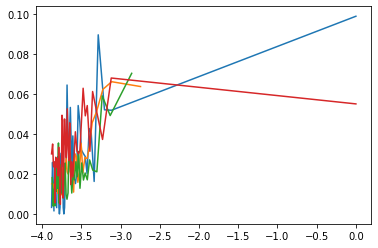

In [202]:
spkNL,binEdges = empiricalNonlinearity(gf.flatten(), wf.flatten(), nbins=20)

exclusion = [[-50, -15], [-20, 0], [-10, 10], [0, 20]]
w = [[-20,-10],[-10,0], [0,5], [5,10]]
for i in range(len(w)):
    xax = np.array(xax)
    iix = np.logical_and(xax > w[i][0], xax < w[i][1])
    xix = np.logical_and(xax > exclusion[i][0], xax < exclusion[i][1])
    iiy = np.sum(sacs[:,xix], axis=1)==0

    iiz = np.outer(iiy, iix)
    spkNL,binEdges = empiricalNonlinearity(gf[iiz], wf[iiz], nbins=50)
    plt.plot(binEdges, gaussian_filter(spkNL, .5))
    
# plt.plot(binEdges, np.log(1 + np.exp(binEdges)))

In [162]:
w = [[-10,0], [0,5], [5,10]]
w[0]

[-10, 0]

In [ ]:
# snippet from Dan
ndn3 = NDN.NDN([stim_par, sac_on_par, sac_off_par, sac_mid_par, comb_par], noise_dist='poisson')
ndn3.networks[1].layers[0].init_temporal_basis( xs=tspacing )
ndn3.networks[2].layers[0].init_temporal_basis( xs=tspacingOff )


sac_on_par = NDNutils.ffnetwork_params(      input_dims=[1,1,1], time_expand=[num_onlags],     xstim_n=[1],     layer_sizes=[NC], # conv_filter_widths=[1],      layer_types=['temporal'], act_funcs=['lin'],      normalization=[0],     reg_list={'d2t':[0.01],'l2':[None], 'l1':[None]})  sac_off_par = NDNutils.ffnetwork_params(      input_dims=[1,1,1], time_expand=[num_offlags],     xstim_n=[2],     layer_sizes=[NC], # conv_filter_widths=[1],      layer_types=['temporal'], act_funcs=['lin'],      normalization=[0],     reg_list={'d2t':[0.001],'l2':[None], 'l1':[None]})   comb_par = NDNutils.ffnetwork_params(     xstim_n=None, ffnet_n=[0,1,2], layer_sizes=[NC],     layer_types=['add'], act_funcs=['softplus'])  # initialize NDN ndn2 = NDN.NDN([stim_par, sac_on_par, sac_off_par, comb_par], noise_dist='poisson') ndn2.networks[1].layers[0].init_temporal_basis( xs=tspacing ) ndn2.networks[2].layers[0].init_temporal_basis( xs=tspacingOff )